# Run Spectractor

The goal of this notebook is to run Spectractor on individual exposures for plotting and debugging purposes.

## Checks and loads

In [2]:
!eups list -s | grep LOCAL

atmospec              LOCAL:/home/j/jneveu/repos/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/j/jneveu/repos/SpectractorDESC 	setup


In [3]:
from lsst.atmospec.utils import runNotebook
%matplotlib widget

In [4]:
import getObsAtmo

getObsAtmo.ObsAtmo(obs_str='AUXTEL', pressure=800)

AUXTEL site name validated as LSST observatory


In [5]:
import getCalspec

c = getCalspec.Calspec("hd167060")
getCalspec.__file__

'/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/getCalspec/__init__.py'

## Config

In [7]:
from lsst.atmospec.processStar import ProcessStarTaskConfig
psConfig = ProcessStarTaskConfig

configOptions = {'isr': {'doFlat': False, 'doApplyGains': False, 'usePtcGains': True}, 
                 'characterizeImage': {'repair.doCosmicRay': True, 'doMaskStreaks': False, 'detection.includeThresholdMultiplier': 3},
                 'processStar': {'rebin': 2, 
                                 'spectralOrder':1,
                                  #'backgroundWidth': 120,
                                  'deconvolutionSigmaClip': 100,
                                  'doDeconvolveSpectrum': True,
                                  'doFullForwardModelDeconvolution': True,
                                  'doFitAtmosphere': True,
                                  'doFitAtmosphereOnSpectrogram': True,
                                  'verbose': True,
                                  'instrumentTransmissionOverride': 'multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt',
                                  'spectractorDebugLogging': False,
                                  'spectractorDebugMode': True}}

## Pick your exposure and run

In [ ]:
dataId = {'day_obs': 20200315, 'seq_num': 192, 'detector':0}
#dataId = {'day_obs': 20220316, 'seq_num': 357, 'detector':0}
dataId = {'day_obs': 20220316, 'seq_num': 330, 'detector':0}
#dataId = {'day_obs': 20230118, 'seq_num': 573, 'detector':0}
#dataId = {'day_obs': 20230117, 'seq_num': 505, 'detector':0}
#dataId = {"day_obs": 20230118, "seq_num": 573, "detector": 0}
#dataId = {"day_obs": 20230117, "seq_num": 265, "detector": 0}
#dataId = {"day_obs": 20230511, "seq_num": 252, "detector": 0}
#dataId = {"day_obs": 20230216, "seq_num": 257, "detector": 0}
#dataId = {"day_obs": 20230511, "seq_num": 252, "detector": 0}
#dataId = {"day_obs": 20230817, "seq_num": 357, "detector": 0}
#dataId = {"day_obs": 20230802, "seq_num": 604, "detector": 0}
#dataId = {"day_obs": 20230928, "seq_num": 306, "detector": 0}
dataId = {"day_obs": 20230928, "seq_num": 266, "detector": 0}
#dataId = {"day_obs": 20230928, "seq_num": 267, "detector": 0}
#dataId = {"day_obs": 20240212, "seq_num": 473, "detector": 0}
#dataId = {"day_obs": 20211103, "seq_num": 539, "detector": 0}
#dataId = {"day_obs": 20231128, "seq_num": 409, "detector": 0}
#dataId = {"day_obs": 20231128, "seq_num": 410, "detector": 0}
#dataId = {"day_obs": 20230927, "seq_num": 414, "detector": 0}
#dataId = {"day_obs": 20230927, "seq_num": 415, "detector": 0}
#dataId = {"day_obs": 20231204, "seq_num": 448, "detector": 0}
#dataId = {"day_obs": 20240205, "seq_num": 33, "detector": 0}
outputCollection = 'u/jneveu/testing62'

spec = runNotebook(dataId, outputCollection, taskConfigs={}, configOptions=configOptions, embargo=True, extraInputCollections=['u/cslage/sdf/latiss/ptc_20220927J'])

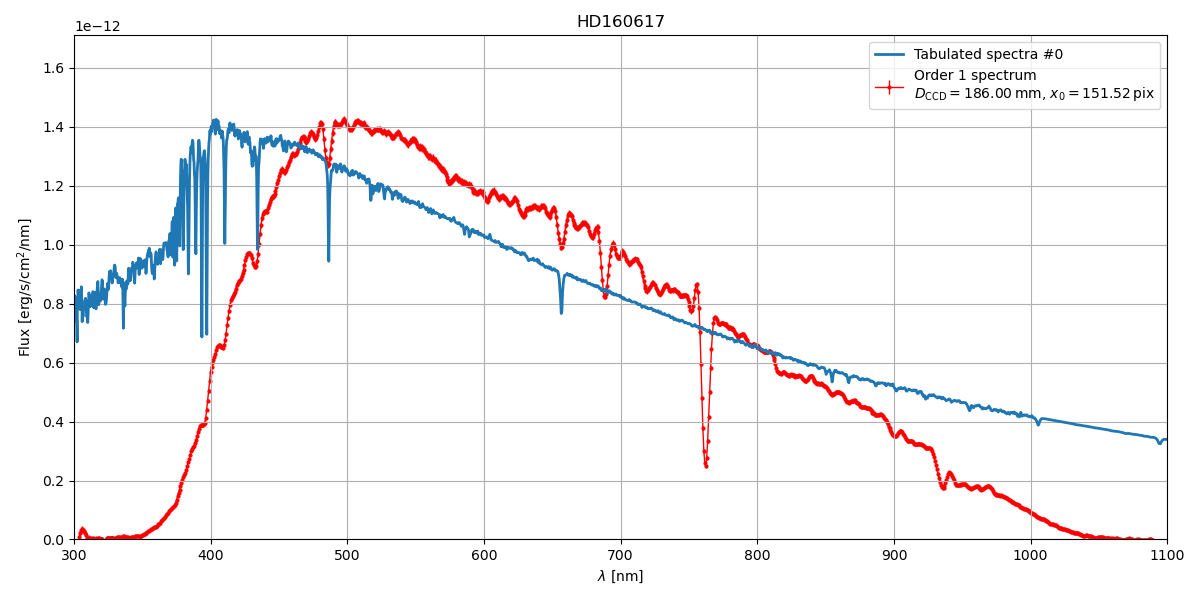

In [9]:
%matplotlib widget
spec.plot_spectrum()

## Save spectrum to short-cut further studies

In [ ]:
#image.save_image("./test_auxtel_image.fits", overwrite=True)
spec.save_spectrum("./test_auxtel_spectrum.fits", overwrite=True)

## Check saved parameters

In [ ]:
import lsst.daf.butler as dafButler
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
p = butler.get('spectrumForwardModelFitParameters', dataId=dataId, collections=outputCollection, detector=0, instrument='LATISS')
p

In [ ]:
p = butler.get('spectrogramForwardModelFitParameters', dataId=dataId, collections=outputCollection, detector=0, instrument='LATISS')
p

## Short-cut to test atmospheric extraction on FITS spectrum

In [ ]:
from spectractor.fit.fit_spectrogram import SpectrogramFitWorkspace, run_spectrogram_minimisation
from spectractor.fit.fit_spectrum import SpectrumFitWorkspace, run_spectrum_minimisation
from spectractor.extractor.spectrum import Spectrum
from spectractor import parameters
parameters.VERBOSE = True
parameters.DEBUG = True

In [ ]:
spec2 = Spectrum("./test_auxtel_spectrum.fits")
%matplotlib widget
spec2.plot_spectrum()

In [ ]:
#parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = "multispectra_holo4_003_multi_AuxTel_noflat_throughput.txt"
#parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = "multispectra_holo4_003_HD142331_AuxTel_throughput.txt"

### Spectrum atmospheric fit

In [ ]:
w = SpectrumFitWorkspace(spec2, atmgrid_file_name='', verbose=True, plot=True, live_fit=False, fit_angstrom_exponent=True)
#w.params.values[0] = 0.84
w.simulate(*w.params.values)
w.plot_fit()

In [ ]:
run_spectrum_minimisation(w, method="newton")
w.params.print_parameters_summary()

### Spectrogram atmospheric fit

In [ ]:
w = SpectrogramFitWorkspace(spec2, atmgrid_file_name='', verbose=True, plot=True, live_fit=False, fit_angstrom_exponent=True)
run_spectrogram_minimisation(w, method="newton")
w.params.print_parameters_summary()